In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re

In [34]:
# Load data

In [35]:
df = pd.read_csv('./cow.csv')
df

,surgery,age,hospital_number,temperature,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome Class,surgical_lesion,lesion
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,...,NaN,NaN,distend_large,55.0,65.0,NaN,NaN,euthanized,no,3205
295,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,NaN,absent,distend_small,44.0,NaN,serosanguious,3.3,euthanized,yes,2208
296,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,NaN,decreased,distend_large,60.0,6.8,NaN,NaN,died,yes,3205
297,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,NaN,absent,distend_small,50.0,6.0,serosanguious,3.4,lived,yes,2208


In [36]:
def extract_lesion_column(lesion):
    site, type_l, subtype, code = 'None', 'None', 'None', 'None'
    if lesion != 0:
        types = re.findall('^([1-9]|11|00)([1-4])([0-2])([1-9]|10|0)',str(lesion))
        if types:
            site, type_l, subtype, code = types[0]
    return pd.Series({'lesion_site': site, 'lesion_type': type_l, 'lesion_subtype': subtype, 'lesion_code': code}, dtype='category')

df.loc[:, ['lesion_site', 'lesion_type', 'lesion_subtype', 'lesion_code']] = df.lesion.apply(extract_lesion_column).astype('category')
df.drop(columns=['lesion', 'hospital_number'], inplace=True)

In [37]:
categorical_columns = []
for col in df:
    if str(df[col].dtype) != 'category' and df[col].unique().size < 10:
        df[col].fillna('[NAN]', inplace=True)
        categorical_columns.append(col)
        df[col] = df[col].astype('category')

In [38]:
X = []
X_labels = []
Y = None
for col in df:
    if col == 'outcome Class':
        Y = df[col].cat.codes.values
    elif str(df[col].dtype) != 'category':
        X.append(df[col].fillna(df[col].mean()).values,)
        X_labels.append(col)
    else:
        X.append(df[col].cat.codes.values)
        X_labels.append(col)
X = np.array(X).T
x_label2idx = {l:i for i,l in enumerate(X_labels)}

In [39]:
import sklearn.feature_selection as fs

In [40]:
selector = fs.SelectPercentile(fs.chi2,percentile=10).fit(X, Y)
X_new = selector.transform(X)
keep_cols = selector.scores_.argsort()[::-1][:X_new.shape[1]]
keep_cols_label = [X_labels[i] for i in keep_cols]
keep_cols_label

['total_protein', 'pulse', 'lesion_subtype']

In [41]:
col2types = {l:df[l].dtype.name for l in X_labels}

In [42]:
from sklearn.model_selection import train_test_split
x_train_, x_test_, y_train_, y_test_ = train_test_split(X[:,keep_cols], Y, test_size=0.2)

In [43]:
np.unique(y_test_, return_counts=1),np.unique(y_train_, return_counts=1)

((array([0, 1, 2], dtype=int8), array([14,  7, 39])),
 (array([0, 1, 2], dtype=int8), array([ 63,  37, 139])))

In [44]:
num_classes = np.unique(y_test_).size
num_classes

3

In [45]:
x_train={l:v for l, v in zip(keep_cols_label, x_train_.T)}
x_test={l:v for l, v in zip(keep_cols_label, x_test_.T)}

y_train = tf.keras.utils.to_categorical(y_train_)
y_test = tf.keras.utils.to_categorical(y_test_)

In [46]:
def build_model():
    def _build_input_layer(feature_name):
        if col2types[feature_name] == 'category':
            inputs = tf.keras.layers.Input(shape=(1,), name=feature_name)
            n = np.unique(X[:, x_label2idx[feature_name]]).size
            x = tf.keras.layers.Embedding(n, 128, input_length=1)(inputs)
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(128)(inputs)
            return inputs, x
        else:
            inputs = tf.keras.layers.Input(shape=(1,), name=feature_name)
            x = tf.keras.layers.Dense(128)(inputs)
            return inputs, x

    in_layers = []
    x_layers = []
    for feature in keep_cols_label:
        il, xl = _build_input_layer(feature)
        in_layers.append(il)
        x_layers.append(xl)

    x = tf.keras.layers.Concatenate()(x_layers)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Average()(x_layers + [x])
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=in_layers, outputs=x, name='model')

model=build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 total_protein (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 pulse (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 lesion_subtype (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 128)          256         ['total_protein[0][0]']          
                                                                                              

In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

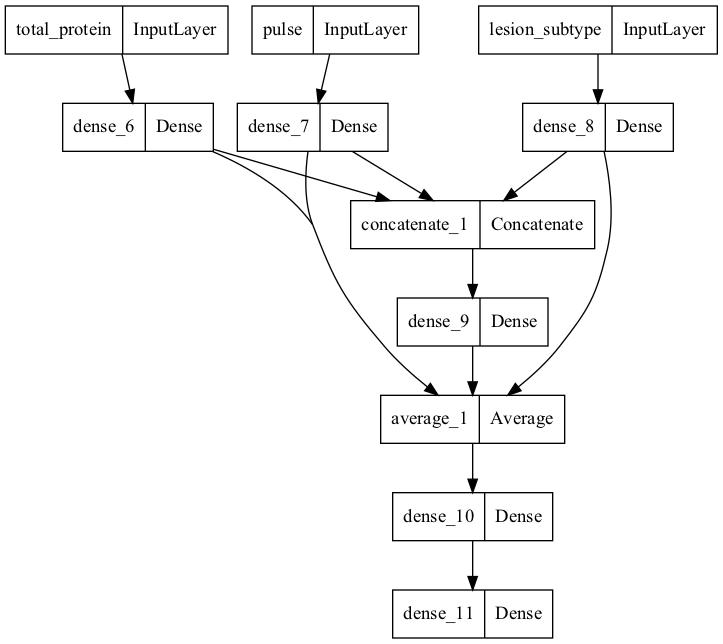

In [48]:
tf.keras.utils.plot_model(model)

In [63]:
fit_history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 13ms/step - loss: 0.5984 - accuracy: 0.7155 - recall_1: 0.6736 - val_loss: 0.7127 - val_accuracy: 0.7833 - val_recall_1: 0.7833
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6050 - accuracy: 0.7197 - recall_1: 0.6569 - val_loss: 0.7167 - val_accuracy: 0.8000 - val_recall_1: 0.7000
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5918 - accuracy: 0.7448 - recall_1: 0.6736 - val_loss: 0.7272 - val_accuracy: 0.8000 - val_recall_1: 0.7833
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6010 - accuracy: 0.7071 - recall_1: 0.6318 - val_loss: 0.7570 - val_accuracy: 0.7833 - val_recall_1: 0.6667
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5986 - accuracy: 0.7238 - recall_1: 0.6402 - val_loss: 0.7041 - val_accuracy: 0.8167 - val_recall_1: 0.7667
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6203 - accuracy: 0.74

8/8 [==============================] - 0s 6ms/step - loss: 0.5998 - accuracy: 0.7280 - recall_1: 0.6276 - val_loss: 0.7308 - val_accuracy: 0.8000 - val_recall_1: 0.6667
Epoch 47/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6242 - accuracy: 0.6946 - recall_1: 0.6402 - val_loss: 0.7905 - val_accuracy: 0.7667 - val_recall_1: 0.7500
Epoch 48/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6079 - accuracy: 0.7322 - recall_1: 0.6778 - val_loss: 0.7392 - val_accuracy: 0.8000 - val_recall_1: 0.6667
Epoch 49/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5905 - accuracy: 0.7364 - recall_1: 0.6151 - val_loss: 0.7463 - val_accuracy: 0.8000 - val_recall_1: 0.7500
Epoch 50/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5840 - accuracy: 0.7280 - recall_1: 0.6946 - val_loss: 0.7251 - val_accuracy: 0.8000 - val_recall_1: 0.7500
Epoch 51/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5879 - accuracy: 0.7364 - rec

8/8 [==============================] - 0s 6ms/step - loss: 0.5709 - accuracy: 0.7322 - recall_1: 0.6862 - val_loss: 0.7778 - val_accuracy: 0.7833 - val_recall_1: 0.7500
Epoch 92/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5758 - accuracy: 0.7322 - recall_1: 0.6569 - val_loss: 0.7421 - val_accuracy: 0.8167 - val_recall_1: 0.7000
Epoch 93/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5823 - accuracy: 0.7531 - recall_1: 0.6318 - val_loss: 0.7742 - val_accuracy: 0.8000 - val_recall_1: 0.7333
Epoch 94/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5941 - accuracy: 0.7155 - recall_1: 0.6862 - val_loss: 0.8026 - val_accuracy: 0.7833 - val_recall_1: 0.7833
Epoch 95/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5778 - accuracy: 0.7364 - recall_1: 0.6695 - val_loss: 0.7917 - val_accuracy: 0.8167 - val_recall_1: 0.6500
Epoch 96/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5924 - accuracy: 0.7280 - rec

Epoch 136/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5731 - accuracy: 0.7364 - recall_1: 0.6402 - val_loss: 0.7788 - val_accuracy: 0.8167 - val_recall_1: 0.7667
Epoch 137/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5638 - accuracy: 0.7364 - recall_1: 0.6987 - val_loss: 0.7927 - val_accuracy: 0.8000 - val_recall_1: 0.7667
Epoch 138/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5603 - accuracy: 0.7490 - recall_1: 0.7029 - val_loss: 0.7908 - val_accuracy: 0.8167 - val_recall_1: 0.7167
Epoch 139/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5644 - accuracy: 0.7573 - recall_1: 0.6695 - val_loss: 0.7908 - val_accuracy: 0.8333 - val_recall_1: 0.7333
Epoch 140/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5762 - accuracy: 0.7238 - recall_1: 0.6318 - val_loss: 0.7768 - val_accuracy: 0.8000 - val_recall_1: 0.7667
Epoch 141/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5836 - acc

Epoch 181/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5639 - accuracy: 0.7406 - recall_1: 0.6025 - val_loss: 0.8049 - val_accuracy: 0.8167 - val_recall_1: 0.7667
Epoch 182/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5624 - accuracy: 0.7490 - recall_1: 0.7029 - val_loss: 0.8069 - val_accuracy: 0.8167 - val_recall_1: 0.8167
Epoch 183/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.7531 - recall_1: 0.6862 - val_loss: 0.8206 - val_accuracy: 0.8167 - val_recall_1: 0.7333
Epoch 184/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5660 - accuracy: 0.7406 - recall_1: 0.6736 - val_loss: 0.8312 - val_accuracy: 0.8000 - val_recall_1: 0.7667
Epoch 185/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5598 - accuracy: 0.7406 - recall_1: 0.6820 - val_loss: 0.8100 - val_accuracy: 0.8333 - val_recall_1: 0.7833
Epoch 186/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5731 - acc

Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5674 - accuracy: 0.7490 - recall_1: 0.6025 - val_loss: 0.8416 - val_accuracy: 0.8167 - val_recall_1: 0.7333
Epoch 227/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5563 - accuracy: 0.7364 - recall_1: 0.7113 - val_loss: 0.8353 - val_accuracy: 0.8167 - val_recall_1: 0.8000
Epoch 228/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5619 - accuracy: 0.7197 - recall_1: 0.6695 - val_loss: 0.8456 - val_accuracy: 0.8000 - val_recall_1: 0.7333
Epoch 229/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5698 - accuracy: 0.7322 - recall_1: 0.7071 - val_loss: 0.8335 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 230/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5846 - accuracy: 0.7155 - recall_1: 0.6485 - val_loss: 0.8063 - val_accuracy: 0.8167 - val_recall_1: 0.7500
Epoch 231/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5624 - acc

Epoch 271/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5522 - accuracy: 0.7448 - recall_1: 0.6695 - val_loss: 0.8509 - val_accuracy: 0.8000 - val_recall_1: 0.7500
Epoch 272/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5697 - accuracy: 0.7197 - recall_1: 0.6862 - val_loss: 0.8507 - val_accuracy: 0.8000 - val_recall_1: 0.7167
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5535 - accuracy: 0.7448 - recall_1: 0.6695 - val_loss: 0.8595 - val_accuracy: 0.8167 - val_recall_1: 0.7667
Epoch 274/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5785 - accuracy: 0.7364 - recall_1: 0.6904 - val_loss: 0.8637 - val_accuracy: 0.8000 - val_recall_1: 0.7833
Epoch 275/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5648 - accuracy: 0.7448 - recall_1: 0.6569 - val_loss: 0.8606 - val_accuracy: 0.8167 - val_recall_1: 0.6667
Epoch 276/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5621 - acc

Epoch 316/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5467 - accuracy: 0.7406 - recall_1: 0.7029 - val_loss: 0.8773 - val_accuracy: 0.8000 - val_recall_1: 0.7333
Epoch 317/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5934 - accuracy: 0.7573 - recall_1: 0.6067 - val_loss: 0.8927 - val_accuracy: 0.8167 - val_recall_1: 0.6833
Epoch 318/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5657 - accuracy: 0.7364 - recall_1: 0.6862 - val_loss: 0.9349 - val_accuracy: 0.8000 - val_recall_1: 0.8000
Epoch 319/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5460 - accuracy: 0.7615 - recall_1: 0.7071 - val_loss: 0.8849 - val_accuracy: 0.8167 - val_recall_1: 0.6833
Epoch 320/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5581 - accuracy: 0.7490 - recall_1: 0.6653 - val_loss: 0.8827 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 321/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5455 - acc

Epoch 361/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.7531 - recall_1: 0.6653 - val_loss: 0.9466 - val_accuracy: 0.8000 - val_recall_1: 0.7500
Epoch 362/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5460 - accuracy: 0.7573 - recall_1: 0.6653 - val_loss: 0.9131 - val_accuracy: 0.8167 - val_recall_1: 0.7667
Epoch 363/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5496 - accuracy: 0.7448 - recall_1: 0.7113 - val_loss: 0.8970 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 364/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5692 - accuracy: 0.7322 - recall_1: 0.6611 - val_loss: 0.9189 - val_accuracy: 0.8333 - val_recall_1: 0.7167
Epoch 365/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5445 - accuracy: 0.7573 - recall_1: 0.6904 - val_loss: 0.9204 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 366/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5580 - acc

Epoch 406/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5470 - accuracy: 0.7531 - recall_1: 0.6987 - val_loss: 0.9333 - val_accuracy: 0.8167 - val_recall_1: 0.7333
Epoch 407/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5589 - accuracy: 0.7448 - recall_1: 0.6862 - val_loss: 0.9692 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 408/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5377 - accuracy: 0.7448 - recall_1: 0.7197 - val_loss: 0.9213 - val_accuracy: 0.8333 - val_recall_1: 0.7667
Epoch 409/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5423 - accuracy: 0.7615 - recall_1: 0.6862 - val_loss: 0.9410 - val_accuracy: 0.8333 - val_recall_1: 0.7667
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5362 - accuracy: 0.7615 - recall_1: 0.6862 - val_loss: 0.9860 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 411/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5564 - a

Epoch 451/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5775 - accuracy: 0.7573 - recall_1: 0.7029 - val_loss: 1.0288 - val_accuracy: 0.7833 - val_recall_1: 0.7333
Epoch 452/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5657 - accuracy: 0.7280 - recall_1: 0.6820 - val_loss: 0.9895 - val_accuracy: 0.7833 - val_recall_1: 0.7500
Epoch 453/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5706 - accuracy: 0.7364 - recall_1: 0.7071 - val_loss: 0.9692 - val_accuracy: 0.7833 - val_recall_1: 0.7833
Epoch 454/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5660 - accuracy: 0.7448 - recall_1: 0.7155 - val_loss: 1.0501 - val_accuracy: 0.8000 - val_recall_1: 0.7667
Epoch 455/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5506 - accuracy: 0.7615 - recall_1: 0.7280 - val_loss: 1.0196 - val_accuracy: 0.8000 - val_recall_1: 0.7500
Epoch 456/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5338 - acc

Epoch 496/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5358 - accuracy: 0.7741 - recall_1: 0.6820 - val_loss: 1.0137 - val_accuracy: 0.8167 - val_recall_1: 0.7000
Epoch 497/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5296 - accuracy: 0.7573 - recall_1: 0.7406 - val_loss: 1.0730 - val_accuracy: 0.8000 - val_recall_1: 0.8000
Epoch 498/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5270 - accuracy: 0.7657 - recall_1: 0.7364 - val_loss: 1.0240 - val_accuracy: 0.8000 - val_recall_1: 0.7167
Epoch 499/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5227 - accuracy: 0.7657 - recall_1: 0.7197 - val_loss: 1.0244 - val_accuracy: 0.8167 - val_recall_1: 0.7833
Epoch 500/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5250 - accuracy: 0.7699 - recall_1: 0.7280 - val_loss: 1.0308 - val_accuracy: 0.8167 - val_recall_1: 0.7833


In [64]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 1.0308 - accuracy: 0.8167 - recall_1: 0.7833


[1.0307866334915161, 0.8166666626930237, 0.7833333611488342]

In [65]:
model.save('models/nn_model.keras')

In [66]:
loaded_model=tf.keras.models.load_model('models/nn_model.keras')
loaded_model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 1.0308 - accuracy: 0.8167 - recall_1: 0.7833


[1.0307866334915161, 0.8166666626930237, 0.7833333611488342]

# Test performance

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [68]:
y_preds = model.predict(x_test).argmax(1)

2/2 [==============================] - 0s 2ms/step


In [69]:
outcome_classes = df['outcome Class'].cat.categories.tolist()

In [70]:
print(classification_report(y_test.argmax(1), y_preds, target_names=outcome_classes))

              precision    recall  f1-score   support

        died       0.62      0.93      0.74        14
  euthanized       1.00      0.29      0.44         7
       lived       0.92      0.87      0.89        39

    accuracy                           0.82        60
   macro avg       0.85      0.70      0.69        60
weighted avg       0.86      0.82      0.81        60



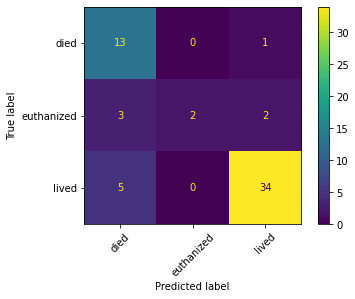

In [71]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test.argmax(1), y_preds),display_labels=outcome_classes
).plot(xticks_rotation=45)